# Import Files

In [ ]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch

from scipy import stats

In [3]:
with open('models/residual_model.pkl', 'rb') as f:
    r_model = pickle.load(f)

with open('models/trend_model.pkl', 'rb') as f:
    t_model = pickle.load(f)

# Analysis of Residual Model

From the forecasted residuals, even though the residuals going to 0 is a design of an AR model with small coefficients and no intercept, we see that it does not accurately reflect reality.

Moreover, an AR(15) model is overly complicated and can be simplified much further. Hence, a different method should be used.

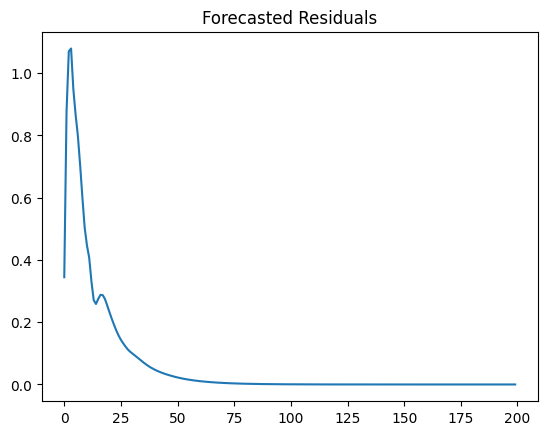

In [4]:
def get_residual_data(residual_model, forecast_t:int=0) -> np.array:
    result = residual_model.forecast(forecast_t)
    return result.values

forecast_resid = get_residual_data(r_model, 200)
plt.plot(forecast_resid)
plt.title("Forecasted Residuals")
plt.show()

# Analyze Model Results

If we remove the residual model and plot out information regarding the residuals, we see that there is a strong partial correlation at lag 1.

In [5]:
class TemperatureModel:
    def __init__(self, trend_model, residual_model, forecast_t:int, training_periods:int=60753, latest_temp:float=19.4078):
        self.forecast_t = forecast_t
        self.latest_temp = latest_temp
        self.training_periods = training_periods
        self.trend_model = trend_model
        self.residual_model = residual_model
        
    def get_seasonal_data(self, forecast_t:int, training_periods:int=60753) -> np.array:
        t = forecast_t + training_periods
        time = np.arange(training_periods+1, t+1)
        omega = 2*np.pi/365
        ot = omega*time
        
        a = 3.4997*np.cos(ot)
        b = 2.7523*np.sin(ot)
        c = -0.3661*np.cos(2*ot)
        d = -0.1726*np.sin(2*ot)
        result = a+b+c+d
        return result
    
    def get_trend_data(self, forecast_t:int=0, latest_temp:float=19.4078, fitted_val:bool=False) -> np.array:
        standardized_forecasts = self.trend_model.fittedvalues if fitted_val else self.trend_model.forecast(forecast_t)
        TREND_STD = 0.0007483
        TREND_MEAN = 0.00003993
        
        forecasts = standardized_forecasts*TREND_STD + TREND_MEAN
        result = latest_temp + np.cumsum(forecasts)
        return result.values
    
    def get_fitted_temps(self) -> np.array:
        self.past_trend = self.get_trend_data(fitted_val=True) 
        self.past_seasonal = self.get_seasonal_data(self.training_periods, 0)
        self.fitted_temp = self.past_seasonal[1:] + self.past_trend #Indexed to account for lag in Trend model
    
    def pipeline(self) -> np.array:
        self.seasonal = self.get_seasonal_data(self.forecast_t, self.training_periods)
        self.trend = self.get_trend_data(self.forecast_t, self.latest_temp)
        self.forecast = self.seasonal + self.trend

In [6]:
forecast = TemperatureModel(t_model, r_model, 30)
forecast.get_fitted_temps()
hist = pd.read_csv('dataset/historical_temp.csv')
residuals = hist['T_AVG'][1:].values - forecast.fitted_temp

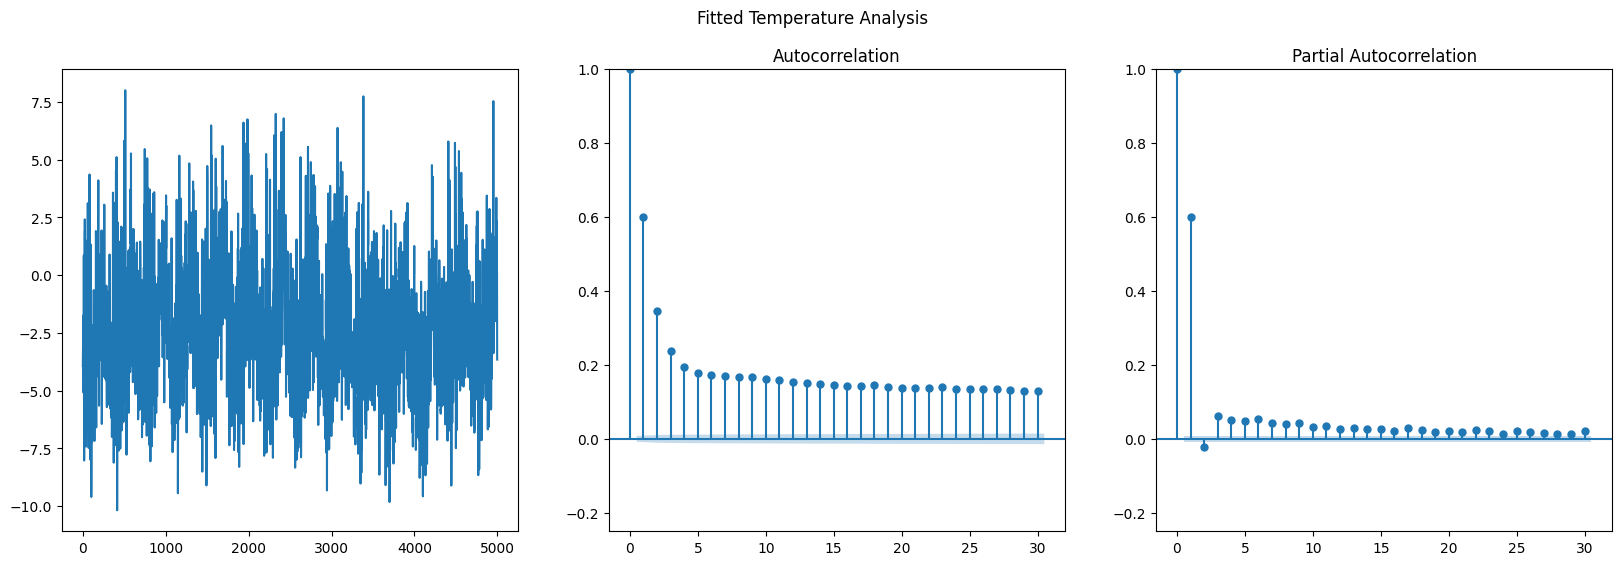

In [7]:
fig, axes = plt.subplots(ncols=3, figsize=(20,6))
fig.suptitle('Fitted Temperature Analysis')

axes[0].plot(residuals[-5000:])

plot_acf(residuals, lags=30, ax=axes[1])
axes[1].set_ylim([-0.25, 1])

plot_pacf(residuals, lags=30, ax=axes[2])
axes[2].set_ylim([-0.25, 1])

plt.show()

# Mean-Reverting Process
The best model to describe temperature data is a mean-reverting process, or more specifically the Ornstein-Uhlenbeck process.
$$dT_t = \kappa(\mu - T_t)dt + \sigma{dW_t}$$

If we follow the same steps to solve the Vasicek Mean-Reverting Process by letting $X_t = e^{\kappa{t}}T_t$

$$dX_t = f_{t}dt + f_{T}dT + \frac{1}{2}f_{TT}(dT)^2$$
$$dX_t = \kappa{e^{\kappa{t}}}T_tdt + e^{\kappa{t}}dT + 0$$
$$dX_t = \kappa{e^{\kappa{t}}}T_tdt + e^{\kappa{t}}(\kappa(\mu - T_t)dt + \sigma{dW_t})$$
$$dX_t = \kappa\mu{e^{\kappa{t}}}dt + \sigma{e^{\kappa{t}}}{dW_t}$$

Now, instead of setting the origin to be 0, we will use $s$ to model a reversion to a changing mean temperature by assuming that temperature follows a Markov chain:
$$X_t - X_s = \kappa{\int_{s}^{t}e^{\kappa{u}}}\mu{du} + \sigma{\int_{s}^{t}e^{\kappa{u}}}{dW_u}$$

We also need to change $du$ to $d\bar{T}$ by letting $\bar{T} = \kappa{\mu}$:
$$X_t - X_s = {\int_{s}^{t}e^{\kappa{u}}}{d\bar{T_u}} + \sigma{\int_{s}^{t}e^{\kappa{u}}}{dW_u}$$

Afterwards, we can further simplify to:
$$e^{\kappa{t}}T_t - e^{\kappa{s}}T_s = {\int_{s}^{t}e^{\kappa{u}}}{d\bar{T_u}}+ \sigma{\int_{s}^{t}e^{\kappa{u}}}{dW_u}$$
$$e^{\kappa{t}}T_t = e^{\kappa{s}}T_s + {\int_{s}^{t}e^{\kappa{u}}}{d\bar{T_u}}+ \sigma{\int_{s}^{t}e^{\kappa{u}}}{dW_u}$$
$$T_t = e^{\kappa(s-t)}T_s + {\int_{s}^{t}e^{\kappa(u-t)}}{d\bar{T_u}} + \sigma{\int_{s}^{t}e^{\kappa(u-t)}}{dW_u}$$
$$T_t = e^{-\kappa(t-s)}T_s + [e^{-\kappa(t-u)}\bar{T_u}]^t_s+ \sigma{\int_{s}^{t}e^{-\kappa(t-u)}}{dW_u}$$
$$T_t = e^{-\kappa(t-s)}T_s + [\bar{T_t} - \bar{T_s}e^{-\kappa(t-s)}]+ \sigma{\int_{s}^{t}e^{-\kappa(t-u)}}{dW_u}$$
$$T_t = \bar{T_t} + (T_s - \bar{T_s})e^{-\kappa(t-s)} + \sigma{\int_{s}^{t}e^{-\kappa(t-u)}}{dW_u}$$

Therefore, the temperature process reverts to a non-constant $\bar{T}$:
$$E[T_t] = \bar{T_t} + (T_s - \bar{T_s})e^{-\kappa(t-s)}

In order to adjust the OU process, we have to add a term $\frac{d\bar{T}}{dt}$.
$$dT_t = [\frac{d\bar{T}}{dt} + \kappa(\bar{T}_t - T_t)]dt + \sigma_t{dW_t}$$

The SDE can be solved by multiplying the equation by $e^{\kappa{t}}$, which we will represent as $m$:
$$mdT_u = m{d\bar{T}_u} + m\kappa(\bar{T}_u - T_u)du + m\sigma_t{dW_u}$$
$$mdT_u + m\kappa{T_u}du = m{d\bar{T}_u} + m\kappa\bar{T}_udu + m\sigma_t{dW_u}$$

Notice that we get a result on the LHS and RHS an equation from Ito's product rule on $e^{\kappa{t}}T$, so we can change them to:
$$d({e^{\kappa{t}}T}) = d({e^{\kappa{t}}\bar{T}}) + e^{\kappa{t}}\sigma_t{dW_u}$$

Integrating both sides:
$$e^{\kappa{t}}T = e^{\kappa{t}}\bar{T} + \int^t_0e^{\kappa{t}}\sigma_t{dW_u}$$
$$T = \bar{T} + \int^t_0\sigma_t{dW_u}$$

Lastly, taking expectation we get the desired result:
$$E[T] = \bar{T}$$

# Euler Discretization

Now that we have our modified OU process, we can use Euler discretization on our SDE over the interval between $t \in{[i-1, i]}$:
$$T_i - T_{i-1} = \bar{T_i} - \bar{T}_{i-1} + \kappa({\bar{T}_{i-1}} - T_{i-1}) + z_i\sigma_i$$
where $z_t$ ~ $N(0, 1)$.

Let $\hat{T}_t = T_t - \bar{T}_t$:
$$T_i - \bar{T_i} =  T_{i-1} - \bar{T}_{i-1} + \kappa({\bar{T}_{i-1}} - T_{i-1}) + z_i\sigma_i$$
$$\hat{T}_i = \hat{T}_{i-1} - \kappa(\hat{T}_{i-1}) + z_i\sigma_i$$

Let $\gamma = 1 - \kappa$:
$$\hat{T}_i = \gamma{\hat{T}_{i-1}} + \epsilon_i$$

Then, we realize that the final equation relates back to the AR(1) process identified previously in the PACF chart, which we can easily solve for $\gamma$

Let $\bar{T}_t$ represent our additive trend + seasonal model and $X_t$ represent whatever is left:
$$T_t = \bar{T}_t + X_t$$
$$T_t - \bar{T}_t = X_t$$
$$\hat{T}_t = \gamma{\hat{T}_{i-1}} + \epsilon_i$$

Therefore, an AR(1) model will give us the $\gamma$.

In [8]:
solve_for_gamma = AutoReg(residuals, lags=1, trend='n')
gamma_model_results  = solve_for_gamma.fit()
gamma = gamma_model_results.params
epsilon = gamma_model_results.resid
print(gamma_model_results.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                60752
Model:                     AutoReg(1)   Log Likelihood             -130029.694
Method:               Conditional MLE   S.D. of innovations              2.057
Date:                Fri, 27 Jun 2025   AIC                         260063.388
Time:                        23:17:57   BIC                         260081.417
Sample:                             1   HQIC                        260068.985
                                60752                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.8120      0.002    342.927      0.000       0.807       0.817
                                    Roots                                    
                  Real          Imaginary           M

Since the result is statistically significant and the roots is 1.2315 (>1) indicating a stationary process, we can proceed with $\kappa = 0.188$.

Therefore, our model is represented as:
$$dT_t = {d\bar{T}} + [0.188(\bar{T}_t - T_t)]dt + \sigma_t{dW_t}$$
$$\bar{T}_t = ARIMA(1,1,2) + S_t$$

In order to get $d\bar{T}$, we can simply forecast one time step for ARIMA(1,1,2). However, for $S_t$ we will have to find the first-order derivative:
$$S_t = 3.4997cos(\frac{2\pi{t}}{365}) + 2.7523sin(\frac{2\pi{t}}{365}) - 0.3661cos(\frac{4\pi{t}}{365}) - 0.1726sin(\frac{4\pi{t}}{365})$$

Let $\omega = \frac{2\pi}{365}$:
$$S'_t = -3.4997\omega{sin(\omega{t})} + 2.7523\omega{cos(\omega{t})} + 0.7322\omega{sin(2\omega{t})} - 0.3452\omega{cos(2\omega{t})}$$

However, we have yet to solve for $\sigma_t$, which could be a time-varying volatility component that we need to verify.

# Verification of White Noise Process

Based on the properties of a white noise process, we need to verify constant mean and variance. Moreover, the mean must be equal to 0 or we are introducing a deterministic drift.

Based on our analysis, we have found that:
- Constant Mean
    - There is a deterministic drift with a mean of -0.4821 that is statistically significant, but this can easily be solved by subtracting it and moving that to our trend component.
    - The mean passes the ADF test and is stationary. We can also see a mean-reverting behaviour in the charts.
- Time-Varying Volatility
    - In terms of volatility, we notice that there is level changes indicating. However, it does revert to the long-run average as confirmed by the ADF test on the rolling volatility.
    - Moreover, there is ARCH effect as based on the Engle's ARCH test as there is statistical significance to reject the null hypothesis (no ARCH effect).

Therefore, we are not dealing with a white noise process, but a time-varying mean-reverting volatility component.

In [ ]:
#H0: unit root exists (non-stationary)
def print_adfuller_result(series:pd.Series):
    test = adfuller(series, autolag='AIC')
    print(f'1. ADF: {test[0]:.4f}')
    print(f'2. p-value: {test[1]:.4f}')
    print(f'3. No. Lags: {test[2]}')
    print(f'4. No. Observations Used: {test[3]} or {test[3]/len(series):.2%}')
    print('5. Critical Values:')
    for key,val in test[4].items():
        print(f'\t {key}: {val:.4f}')

Mean of Residuals: -0.4820996342379113
t-stat: -59.4099, p-value: 0.0000

1. ADF: -22.8956
2. p-value: 0.0000
3. No. Lags: 49
4. No. Observations Used: 60701 or 99.92%
5. Critical Values:
	 1%: -3.4305
	 5%: -2.8616
	 10%: -2.5668


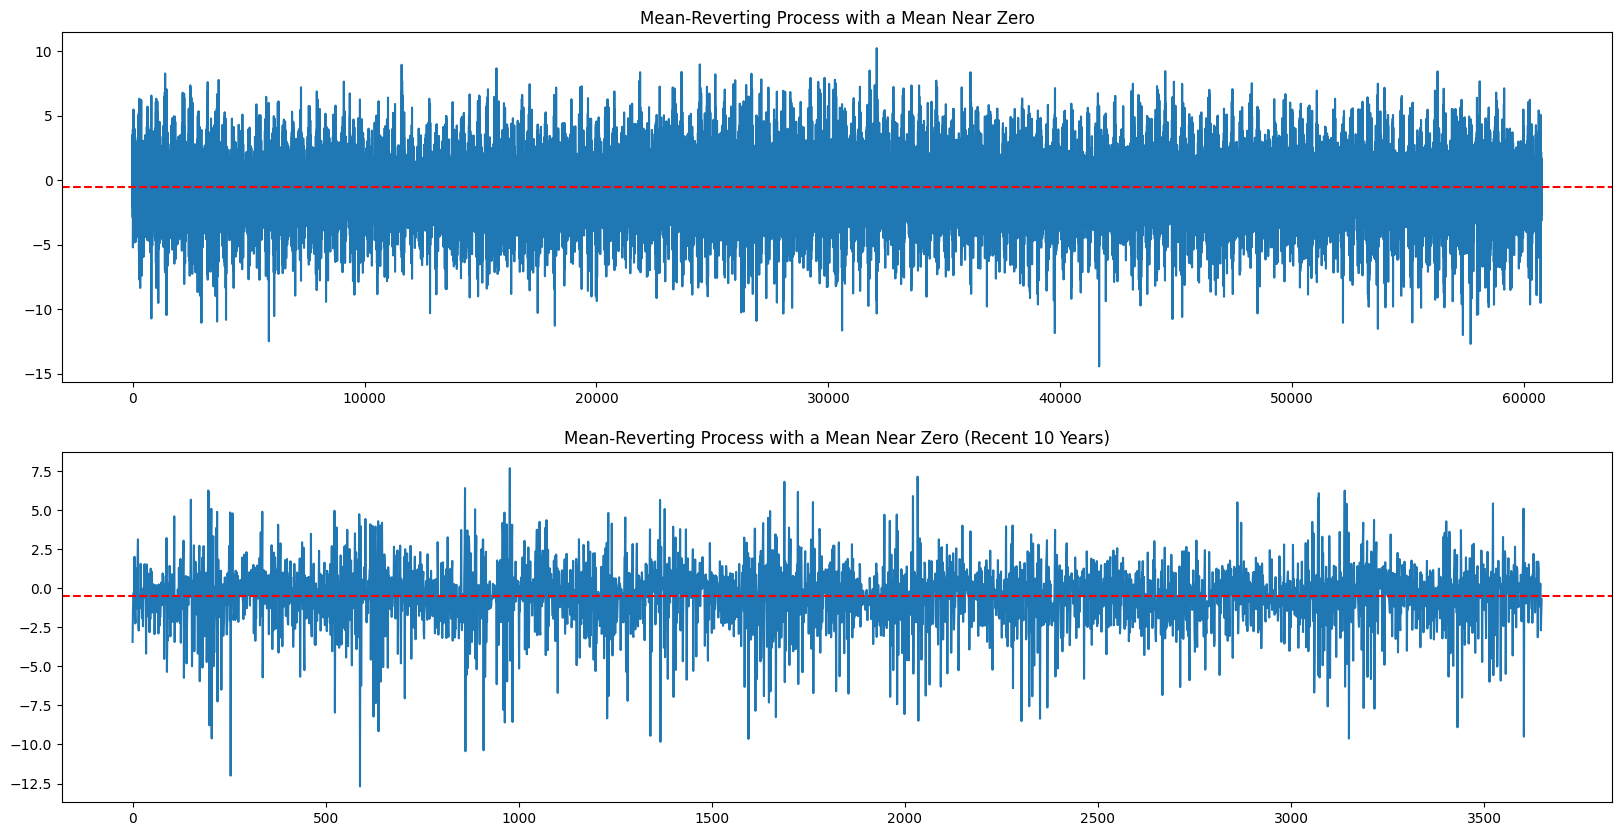

In [41]:
epsilon_mu = epsilon.mean()
print(f'Mean of Residuals: {epsilon_mu}')

std = np.std(epsilon, ddof=1)
n = len(epsilon)
t_stat = epsilon_mu / (std / np.sqrt(n))
p_val = stats.t.sf(np.abs(t_stat), df=n-1) * 2
print(f"t-stat: {t_stat:.4f}, p-value: {p_val:.4f}\n")

print_adfuller_result(epsilon)

fig, axes = plt.subplots(nrows=2, figsize=(20,10))
axes[0].plot(epsilon)
axes[0].axhline(y=epsilon_mu, linestyle='--', color='red')
axes[0].set_title('Mean-Reverting Process with a Mean Near Zero')

axes[1].plot(epsilon[-3650:])
axes[1].axhline(y=epsilon[-3650:].mean(), linestyle='--', color='red')
axes[1].set_title('Mean-Reverting Process with a Mean Near Zero (Recent 10 Years)')

plt.show()

1. ADF: -7.7826
2. p-value: 0.0000
3. No. Lags: 59
4. No. Observations Used: 60327 or 99.90%
5. Critical Values:
	 1%: -3.4305
	 5%: -2.8616
	 10%: -2.5668


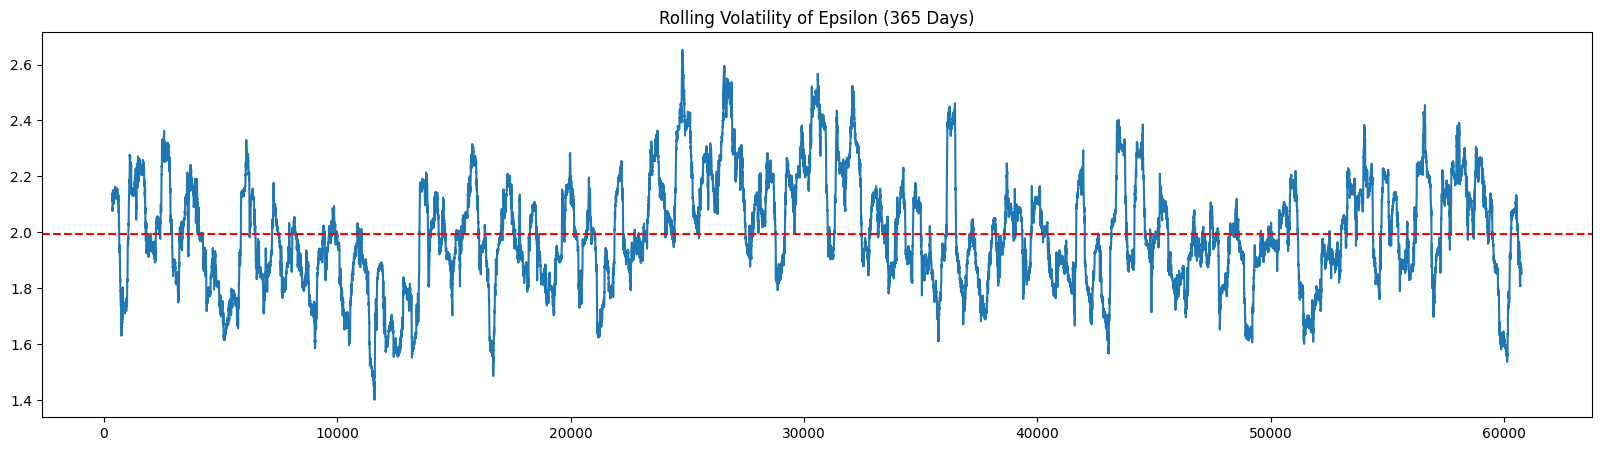

In [48]:
window = 365
rolling_std = pd.Series(epsilon).rolling(window=window).std()
print_adfuller_result(rolling_std.dropna())

plt.figure(figsize=(20, 5))
plt.plot(rolling_std)
plt.title(f'Rolling Volatility of Epsilon ({window} Days)')
plt.axhline(y=rolling_std.mean(), color='red', linestyle='--')
plt.show()

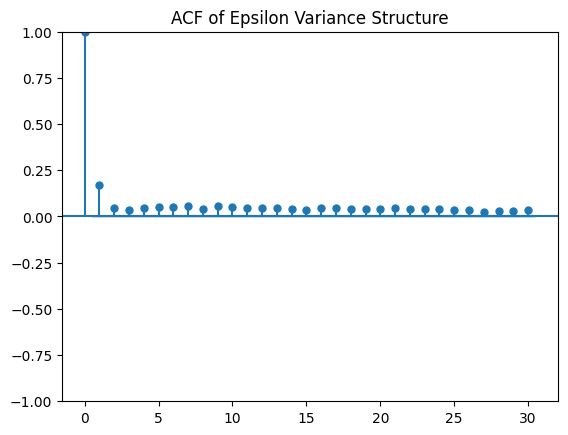

ARCH Test p-value: 0.0000


In [ ]:
plot_acf(epsilon**2, lags=30) #square to look at the variance structure
plt.title('ACF of Epsilon Variance Structure')
plt.show()

#H0: No ARCH effect (constant variance)
arch_test = het_arch(epsilon, nlags= 1) #lags decided based on ACF chart
print(f"ARCH Test p-value: {arch_test[1]:.4f}")

# Model Limitations

1. As this project was to learn about time-series, there were a lot of gaps in knowledge. One of which was combining a continuous process with a discrete time component, in the end, we tried to model the temperature data as a modified OU + Heston continuous time process. However in the modified OU process, we used an ARIMA(1,1,2) model that only functions in discrete time. Luckily in our case, since we are utilizing daily temperature, the ARIMA model is still a decent approximation.